In [1]:
import numpy as np
import pandas as pd
import json
import io
import os
import sys
import pickle
import math
import random

import matplotlib.pyplot as plt

In [2]:
def EMD(Z_i, Z_global):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))


In [3]:
NO_CLIENTS = 56
NO_GROUPS = 7
NO_CLASSES = 10
ALPHA = "03"

In [4]:
path = f"../data/32_Cifar10_NIID_{NO_CLIENTS}c_a{ALPHA}/config.json"
conf = json.loads(open(path, "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

main_label_vectors = np.zeros((NO_CLIENTS,NO_CLASSES))
for client_id in range(NO_CLIENTS):
    for class_id in range(NO_CLASSES):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]

In [5]:
weak    = 2_500_000 
# normal1 = 15_000_000
normal = 35_000_000
# normal1 = 80_000_000
# normal2 = 80_000_000
strong  = 80_000_000

bw_types = (["low"]*10) + (["medium"]*36) + (["high"]*10)

lows = [weak] * 10
mediums = [normal] * 36
highs = [strong] * 10
bw = lows + mediums + highs

ids = np.arange(NO_CLIENTS)
random.shuffle(ids)

bws = []
for idx in ids:
    bws.append((bw[idx],bw_types[idx]))

In [6]:
clients_list = []
for idx in range(len(main_label_vectors)):
    clients_list.append(
        {
            "client_id" : idx,
            "bw" : bws[idx][0],
            "bw_type" : bws[idx][1],
            "distribution" : main_label_vectors[idx],
            "group" : None
        }
    )

In [7]:
clients_df = pd.DataFrame(clients_list)
clients_df.head()

,client_id,bw,bw_type,distribution,group
0,0,35000000,medium,"[342.0, 10.0, 537.0, 177.0, 70.0, 0.0, 0.0, 0....",None
1,1,80000000,high,"[6.0, 6.0, 309.0, 1510.0, 0.0, 0.0, 0.0, 0.0, ...",None
2,2,35000000,medium,"[346.0, 0.0, 128.0, 77.0, 189.0, 431.0, 0.0, 0...",None
3,3,2500000,low,"[14.0, 231.0, 2.0, 254.0, 1.0, 9.0, 79.0, 1021...",None
4,4,2500000,low,"[75.0, 468.0, 389.0, 0.0, 2.0, 69.0, 939.0, 0....",None


In [8]:
maindf = clients_df.sort_values("bw")

In [9]:
maindf["group"] = np.repeat(np.arange(7),8)

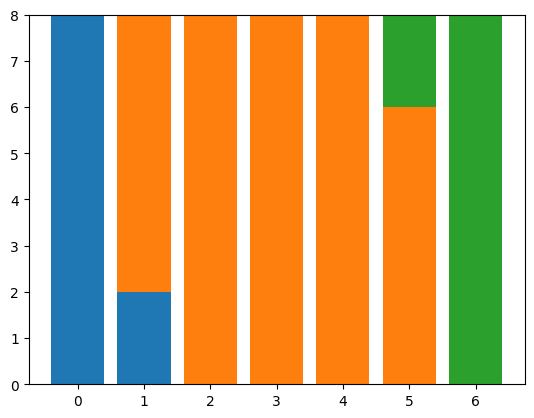

In [10]:
def vis_bw_counts(maindf):
    bw_counts = {
        "low" : [],
        "medium" : [],
        "high" : []
    }
    for group_name, group_df in maindf.groupby("group"):
        group_dict = group_df.groupby("bw_type").count()["client_id"].to_dict()
        for key, value in bw_counts.items():
            try:
                bw_counts[key].append(group_dict[key])
            except:
                bw_counts[key].append(0)

    bw_counts

    fig, ax = plt.subplots()

    ax.bar(np.arange(NO_GROUPS), bw_counts["low"], label="low")
    ax.bar(np.arange(NO_GROUPS), bw_counts["medium"], label="low", bottom=np.array(bw_counts["low"]))
    ax.bar(np.arange(NO_GROUPS), bw_counts["high"], label="low", bottom=np.array(bw_counts["low"]) + np.array(bw_counts["medium"]))

    plt.show()

vis_bw_counts(maindf)

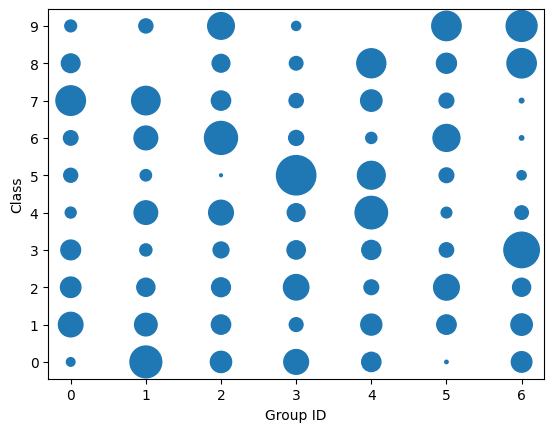

In [11]:
def vis_group_dist(df):

    class_dist = []
    for group_name, group_df in df.groupby("group"):
        class_dist.append(np.sum(group_df.distribution.tolist(),axis=0))
    
    class_dist = np.array(class_dist)
    # print(class_dist)

    x = np.array(np.meshgrid(np.arange(7),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(7),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
    s = class_dist.reshape(1,-1)[0]
    s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*800).astype("int")
    plt.scatter(x,y,s)
    plt.yticks(np.arange(10))
    plt.xlabel("Group ID")
    plt.ylabel("Class")
    plt.show()

vis_group_dist(maindf)


No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7
No operations done : 7


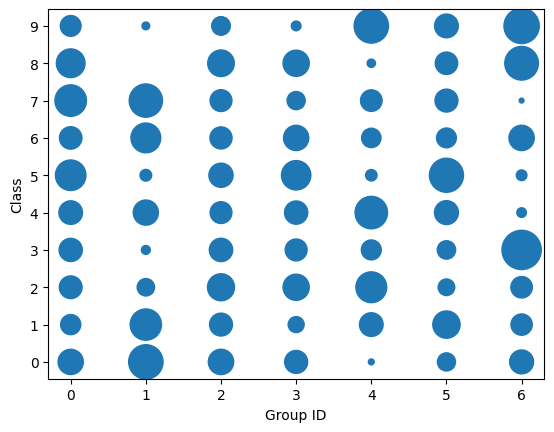

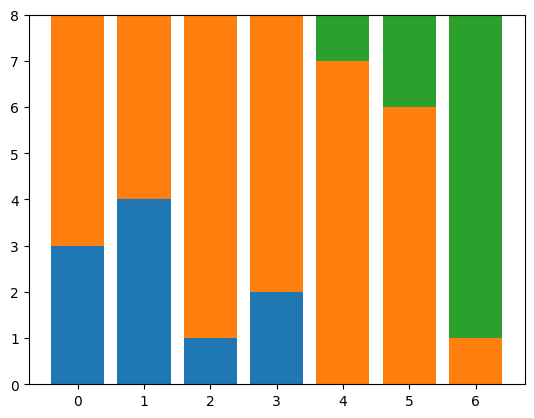

In [13]:
global_dist = np.sum(main_label_vectors, axis=0)

df_iter = maindf.copy()

COEFF = 0.97
all_scores = []

scores = []
for group_no in range(NO_GROUPS-1,-1,-1):
    group_selected = df_iter[df_iter["group"] == group_no]
    group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
    scores.append(EMD(group_dist, global_dist))
all_scores.append(scores)

for iter_no in range(10):
    no_operations_done = 0
    for group_no in range(NO_GROUPS-1,-1,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        
        group_friend_next = df_iter[df_iter["group"] == group_no-1]
        group_friend_prev = df_iter[df_iter["group"] == group_no+1]

        group_friend_next_2 = df_iter[df_iter["group"] == group_no-2]
        group_friend_prev_2 = df_iter[df_iter["group"] == group_no+2]

        candidate_groups = [
            group_friend_next,
            group_friend_prev,
            group_friend_next_2,
            group_friend_prev_2
            ]

        

        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        score = EMD(group_dist, global_dist)
        candidate_operations = []
        for idx, row in group_selected.iterrows():
            client_id = row.client_id
            group_dist_wo = group_dist - np.array(row.distribution)
            bw_type = row.bw_type

            for candidate_group in candidate_groups:
                for idx2, row2 in candidate_group.iterrows():
                    candidate_dist = group_dist + np.array(row2.distribution)
                    candidate_score = EMD(candidate_dist ,global_dist)
                    bw_type_candidate = row2.bw_type
                    if bw_type == bw_type_candidate: coeff = 1
                    else: coeff = COEFF**(iter_no+1)
                    if candidate_score < score*coeff:
                        candidate_operations.append((client_id, row2.client_id, candidate_score))

            # # Select from nextgroup
            # for idx2, row2 in group_friend_next.iterrows():
            #     candidate_dist = group_dist + np.array(row2.distribution)
            #     candidate_score = EMD(candidate_dist ,global_dist)
            #     bw_type_candidate = row2.bw_type
            #     if bw_type == bw_type_candidate: coeff = 1
            #     else: coeff = COEFF
            #     if candidate_score < score*coeff:
            #         candidate_operations.append((client_id, row2.client_id, candidate_score))
            # # Select from prev group
            # for idx3, row3 in group_friend_prev.iterrows():
            #     candidate_dist = group_dist + np.array(row3.distribution)
            #     candidate_score = EMD(candidate_dist ,global_dist)
            #     bw_type_candidate = row3.bw_type
            #     if bw_type == bw_type_candidate: coeff = 1
            #     else: coeff = COEFF
            #     if candidate_score < score*coeff:
            #         candidate_operations.append((client_id, row3.client_id, candidate_score))
        # Transfer operation            
        candidate_operations = np.array(candidate_operations)
        if len(candidate_operations) > 0:
            selected_idx = np.argmin(candidate_operations[:,2])
            selected_operation = candidate_operations[selected_idx]
            # print(selected_operation)
            df_dict = df_iter.to_dict(orient="index")
            main_group = df_dict[selected_operation[0]]["group"]
            other_group = df_dict[selected_operation[1]]["group"]
            # print((main_group, other_group))

            df_iter.at[selected_operation[0], "group"] = other_group
            df_iter.at[selected_operation[1], "group"] = main_group
            no_operations_done += 1

    scores = []
    for group_no in range(NO_GROUPS-1,-1,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        scores.append(EMD(group_dist, global_dist))
    all_scores.append(scores)

    print("No operations done :",no_operations_done)
vis_group_dist(df_iter)
vis_bw_counts(df_iter)

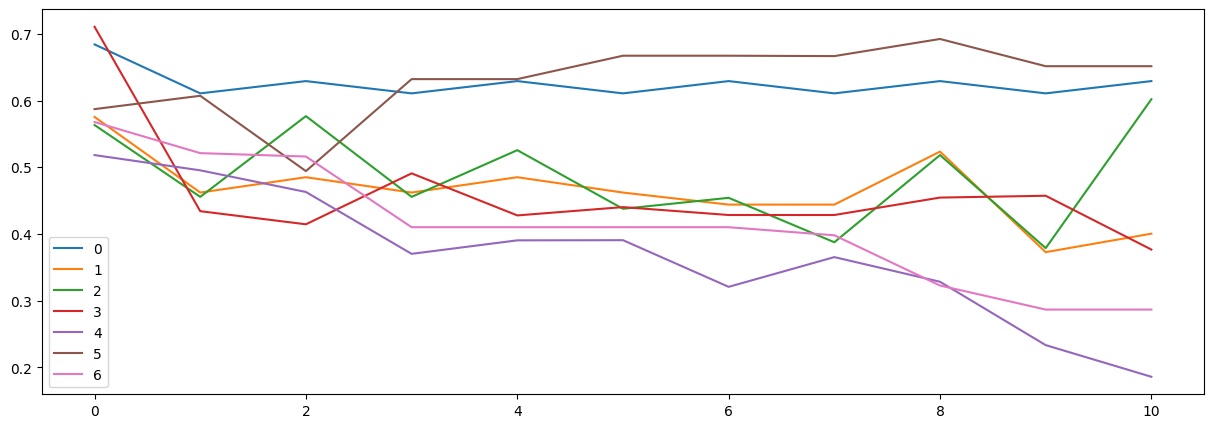

In [14]:
all_scores = np.array(all_scores)


ax = plt.subplots(figsize=(15,5))
for group_no in range(NO_GROUPS):
    plt.plot(all_scores[:,group_no], label=group_no)

plt.legend()
plt.show()

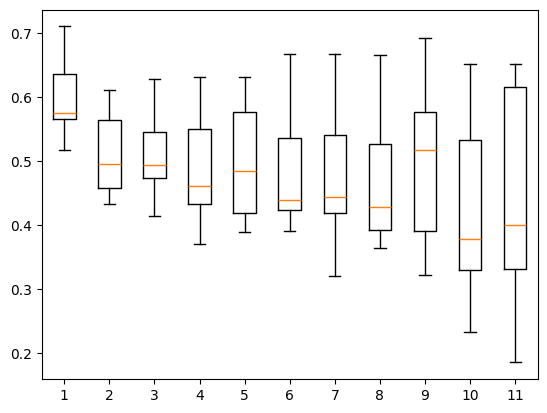

In [15]:
plt.boxplot(all_scores.T)
plt.show()

In [200]:
for iter_no in range(20):
    print(0.97**(iter_no+1))

0.97
0.9409
0.912673
0.8852928099999999
0.8587340256999999
0.8329720049289998
0.8079828447811298
0.7837433594376959
0.7602310586545651
0.7374241268949281
0.7153014030880802
0.6938423609954377
0.6730270901655746
0.6528362774606074
0.6332511891367891
0.6142536534626855
0.5958260438588049
0.5779512625430407
0.5606127246667495
0.543794342926747
